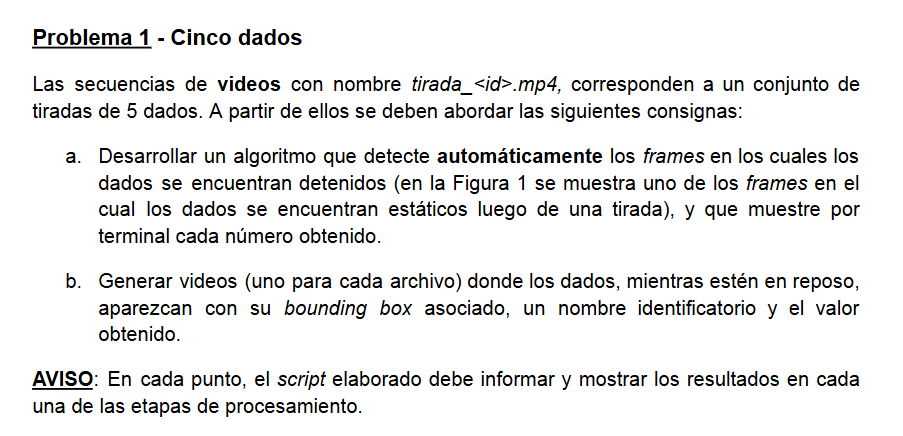

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [60]:
archivo = 'src/tirada_1.mp4' 
archivo_salida = 'resultado_tirada.mp4'

In [61]:
os.makedirs("frames", exist_ok = True) 

In [62]:
#lectura
cap = cv2.VideoCapture(archivo)  
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  
fps = int(cap.get(cv2.CAP_PROP_FPS)) 
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 

print(width)
print(height)
print(fps)
print(n_frames)

1080
2224
30
146


In [63]:
frame_prev = None 
cont_fram_est = 0
cont_frame_global = 0
umbral_mov = 2.0

In [ ]:
#analiza si hay imagen quieta y guarda el frame estatico
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7, 7), 0)

    #detectar movimiento
    es_estatico = False
    if frame_prev is not None:
        frame_diff = cv2.absdiff(frame_prev, blur)   #calcular diferencia entre frames
        motion_score = np.mean(frame_diff)
        
        if motion_score < umbral_mov:
            frames_estaticos += 1
        else:
            frames_estaticos = 0 

        if frames_estaticos > 25:    # quieto 25 frames seguidos
            es_estatico = True
            nombre_archivo = f"frames/frame_{cont_frame_global}.jpg" #guardar frame quieto
            cv2.imwrite(nombre_archivo, frame)
            cont_frame_global += 1

    frame_prev = blur

print(cont_frame_global)

cap.release()
cv2.destroyAllWindows()

5
